In [21]:
!pip install git+https://github.com/jsh9/python-plot-utilities
from brian2 import *
import sympy
import plot_utils

  Cloning https://github.com/jsh9/python-plot-utilities to c:\users\01joja\appdata\local\temp\pip-req-build-_bcj5p8x
  Created wheel for plot-utils: filename=plot_utils-0.6.6-py3-none-any.whl size=13278151 sha256=f3e80f287467a762de78769a87115053006911888e57569b5447a61643b6e195
  Stored in directory: C:\Users\01joja\AppData\Local\Temp\pip-ephem-wheel-cache-jylwto26\wheels\d0\99\78\05b2d3be85d4e5d1f5fec6dcb8ac2b5866bbed0a86fd1756b0
Successfully built plot-utils


Running command git clone -q https://github.com/jsh9/python-plot-utilities 'C:\Users\01joja\AppData\Local\Temp\pip-req-build-_bcj5p8x'


In [14]:
 
def neuron_define(input_neurons):
    input_layer=[*range(0,input_neurons)]
    inhib_layer=[*range(input_neurons,2*input_neurons)]
    left_layer=[*range(2*input_neurons,3*input_neurons-1)]
    right_layer=[*range(3*input_neurons-1,4*input_neurons-2)]
    left_neuron=[4*input_neurons-1]
    right_neuron=[4*input_neurons]
    no_excitatory_neurons= len(input_layer+left_layer+right_layer+left_neuron+right_neuron)
    no_inhibitory_neurons= len(inhib_layer)
    return input_layer, inhib_layer, left_layer, right_layer, left_neuron, right_neuron, no_excitatory_neurons, no_inhibitory_neurons

def synapse_generator(input_neurons):
    i = [] #pre synaptic
    j = [] #post synaptic
    a = neuron_define(input_neurons)
    for index in a[0]:
        #connect the layer between input layer and the inhib layer, a[1] is inhib layer.
        i.append(a[0][index])
        j.append(a[1][index])
        if index != a[0][0]:
            #connect the layer between input layer and the left layer, a[2] is left layer.
            i.append(a[0][index])
            j.append(a[2][index-1])
            #connect the layer between inhib layer and the right layer.
            i.append(a[1][index])
            j.append(a[3][index-1])
        #connect the layer between input layer and the right layer, a[3] is right layer.
        if index != a[0][-1]:
            i.append(a[0][index])
            j.append(a[3][index])
            #connect the layer between inhib layer and the left layer.
            i.append(a[1][index])
            j.append(a[2][index])
            #connect the left layer to the left neuron
            i.append(a[2][index])
            j.append(a[4][0])
            #connect the right layer to the right neuron
            i.append(a[2][index])
            j.append(a[5][0])
        
    return i,j,a[6],a[7]

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1) 
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')
    

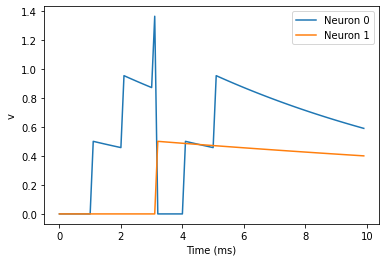

In [35]:
start_scope()

eqs = '''
dv/dt = (I-v)/tau : 1
I : 1
tau : second
'''

indices = [0,0,0,0,0]

input_layer = SpikeGeneratorGroup(1, indices, [1,2,3,4,5]*ms) # assigs 1/4 of the neurons to the input layer

G = NeuronGroup(2, eqs, threshold='v>1', reset='v = 0', method='exact')
G.I = [0, 0]
G.tau = [10, 30]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.5')
S.connect(i=0, j=1)

generate_to_network = Synapses(input_layer, G, on_pre='v_post += 0.5')

#generate_to_network.connect()
generate_to_network.connect(i=0,j=0)
M = StateMonitor(G, 'v', record=True)

run(10*ms)

plot(M.t/ms, M.v[0], label='Neuron 0')
plot(M.t/ms, M.v[1], label='Neuron 1')
xlabel('Time (ms)')
ylabel('v')
legend();